# 1 Introduction
## 1-1 Quantum State Preparation
Quantum state preparation is fundamental to quantum computing. It lies at the heart of quantum algorithms, quantum machine learning, quantum error correction, and quantum physics research, but it can be very difficult to start from an initial state $|0\dots 0 \rangle$ and efficiently prepare an arbitrary state $|\psi \rangle$ with high fidelity. Your objective for this year's Open Science Prize is to significantly improve state-of-the-art state preparation in the context of the Variational Quantum Eigensolver (VQE) algorithm.

The state you will prepare is the highly entangled ground state of a Heisenberg spin-1/2 model on a kagome lattice. That sentence is jam packed with physics jargon, but do not despair. Though the problem statement originates deep within quantum physics research, we will avoid jargon as much as possible. A deep dive into the physics literature (which is very fascinating) is left as an exercise for the reader.

Why the ground state of a Heisenberg model? Well, the ground state of a system is it's lowest energy configuration, and the ground state tends to be where exciting and unexpected quantum affects flourish. For example, when the element Mercury is cooled down near its ground state (below 4 Kelvin), it has no electrical resistance. None. Zero! Near its thermal ground state, a chunk of Mercury is [a superconductor](https://en.wikipedia.org/wiki/History_of_superconductivity). Researchers have been trying to understand what materials exhibit superconductivity and how it's even possible ever since it was first discovered. If that isn't cool enough for you, consider the [Bose-Einstein condensate](https://en.wikipedia.org/wiki/Bose–Einstein_condensate). This is quantum phase of matter where a dilute gas of individual atoms (bosonic atoms such as [Rubidium](https://en.wikipedia.org/wiki/Rubidium))--when cooled to their ground state--effectively become one giant particle!

A system's ground state determines important and fascinating physical properties (see the two examples highlighted above), yet some quantum systems have ground states (and their associated energies) which are difficult to make and measure in the lab as well as being intractable for classical computers to calculate. The Variational Quantum Eigensolver (VQE) is a promising quantum algorithm that could find these ground states and their energies.

You will implement the VQE algorithm on [ibmq_guadalupe](https://quantum-computing.ibm.com/services/resources?system=ibmq_guadalupe) a 16 qubit [heavy-hex](https://research.ibm.com/blog/heavy-hex-lattice) device. This is the largest device used in an Open Science Prize to date. Working with more qubits presents its own challenges. Be mindful of how your solution scales as this will be part of the judging criteria this year.

We'll get more into the principles of VQE later, but for now, remember that VQE relies on iterative cycles of quantum and classical computation. Fast iterations and fast communication between the classical and quantum computer are essential for a fast VQE, and [Qiskit runtime](https://github.com/Qiskit/qiskit-ibm-runtime) does just that. [Qiskit runtime](https://medium.com/qiskit/so-what-is-qiskit-runtime-anyway-c78aecf3742) is a programming model and containerized environment designed to reduce the computational cycle time between quantum and classical computers. Later in this notebook, we will demonstrate how to leverage the latest release of runtime for fast VQE.

The notebook is organized as follows: Section 1 gives a brief introduction to the Heisenberg model, the kagome lattice, and VQE algorithm. It also provides a classical calculation of the ground state(s) energy. Section 2 introduces how to construct a VQE experiment and simulate it on your local computer. Section 3 introduces Qiskit runtime and how to run VQE on a cloud simulator or real backend. Finally, if you are feeling stuck, we've provided some questions to consider as you design and implement your solution.

#### Objective
**Your task is to use the VQE algorithm to compute the ground state of a Heisenberg spin-1/2 system on a kagome lattice unit cell with the lowest possible relative error of the measured state's energy expectation value wrt to the exact value.** There are actually two ground states in this specific case, and you may prepare any combination of the two including only one or the other.


## 1-2 Heisenberg spin-1/2 model on the kagome lattice
For the Open Science Prize, (get ready for some jargon) you will work with the antiferromagnetic $XXX$ Heisenberg model arranged on a kagome lattice. The $XXX$ Heisenberg model Hamiltonian for this Prize will be defined as
$$
\begin{equation}
H = \sum_{\langle i j \rangle}^N X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1}
\end{equation}
$$
where $\langle i j \rangle$ is sum over neighboring spins and $X$, $Y$, and $Z$ are the usual Pauli matrices. The Heisenberg model hosts a wide variety of exotic quantum physics all of which heavily depend on the arrangement of the spins. The arrangement we are interested in is a kagome lattice.

![title](images/kagome_unit_cell.png)

The kagome lattice is a unique lattice structure made up of corner-sharing triangles (see the unit cell above). In general, the kagome lattice (i.e. many unit cells tiled together) is theorized to host a fascinating quantum phase of matter called a quantum spin liquid--a research topic at the forefront of quantum physics [1-3]. Additionally, excitations from that ground state are theorized to show exotic quantum behavior such a fractionalized particle excitations [1-3]. For those interested in a deeper dive into the physics check out Refs. [1-3] and other papers.

This year's Prize will focus on a single unit cell (the base pattern shown above) which has 12 spin-1/2 particles represented in as blue dots in the image below. Each spin will be represented by a single qubit. The lines connecting the spin-1/2 particles called edges--borrowing a term from [graph theory](https://en.wikipedia.org/wiki/Graph_theory)--and they specify which spins are neighbors.

\[1\] "Modern condensed matter physics." Girvin, Steven M., and Kun Yang. Cambridge University Press, (2019).

\[2\] "Spin liquids in frustrated magnets." Balents, Leon. [Nature 464, 199–208](https://doi.org/10.1038/nature08917) (2010). 

\[3\] "Probing topological spin liquids on a programmable quantum simulator." Semeghini, Giulia, et al. [Science 374.6572: 1242-1247.](https://www.science.org/doi/10.1126/science.abi8794) (2021). [arXiv link](https://arxiv.org/abs/2104.04119)

\[4\] "Kagome: The Story of the Basketweave Lattice." Mekata, Mamoru. [Physics Today 56, 2, 12](https://physicstoday.scitation.org/doi/10.1063/1.1564329) (2003).

## 1-3 VQE
The Variational Quantum Eigensolver (VQE) is a quantum algorithm that can find the ground state(s) of a given Hamiltonian [5-7]. The VQE algorithm is based on the [variational principle](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) of quantum mechanics and relies on both quantum and classical computations. Below, we briefly sketch out the main principles of VQE, and encourage you to review educational material and the research literature for details.

Given a Hamiltonian $H$ and ground state $|\psi_g \rangle$, the variational principle says that even if we don't know the exact ground state an approximate ground state $|\tilde{ \psi}_g\rangle \approx |\psi_g \rangle$ can be found. To find the approximate ground state $|\tilde{ \psi}_g\rangle$, we start with a parameterized state called an ansatz $|\psi(\boldsymbol{\theta})\rangle$ where $\boldsymbol{\theta} \equiv (\theta_1, \theta_2,\dots)$ are the parameters. In theory, there is a combination of parameter values where the anstaz approximates the ground state $|\psi(\boldsymbol{\theta})\rangle \approx |\psi_g\rangle$, but we need a way to find those parameter values. This is done with a combination of quantum and classical computing.

To optimize the parameters, many cycles of quantum and classical computing drive the ansatz toward the approximate ground state. The quantum computer computes the energy expectation value of Hamiltonian $H$ acting on the the parameterized anstaz for a given set of parameter values
$$
E(\boldsymbol{\theta}) = \langle \psi(\boldsymbol{\theta}) | H | \psi(\boldsymbol{\theta}) \rangle \;.
$$
For those familiar with optimization terminology this is the cost function. A classical computer uses the measurement data from the quantum computer to determine how the parameters values should be adjusted to further minimize the energy $E(\boldsymbol{\theta})$. As the classical and quantum computer loop through many iterations, they search the parameter space and converge to the approximate ground state.

How can we know the state that gives the minimum energy expectation value is the ground state? The variation principle guarantees that the minimal energy expectation value can only be achieved if the quantum state is the ground state. No other state can give a lower energy--hence the name ground state. In this way, we can be confident that minimizing $E(\boldsymbol{\theta})$ with respect to the parameters $\boldsymbol{\theta}$ will drive the ansatz toward an accurate approximation of the true ground state and not some other state.

Of course, the actual implementation of the algorithm comes with challenges. The ansatz $|\psi(\boldsymbol{\theta})\rangle$ may never reach the ground state for any combination of parameters. The ansatz could have too many parameters and encounter a barren plateau during optimization. When implementing the VQE, it may take an unreasonable amount of time to execute the ansatz or measure the expectation value on quantum hardware. The quantum hardware may be too noisy. The classical optimizer may not pair well with the optimization landscape or the level of noise from the quantum measurements. Etc.

To jump into more details about VQE, we included three review articles on the topic below. We encourage you to review additional educational material and research literature as you work out your solution.

\[5\] "A variational eigenvalue solver on a quantum processor." A. Peruzzo, et al. [arXiv:1304.3061](https://arxiv.org/abs/1304.3061) [quant-ph] (2013).

\[6\] "Variational quantum algorithms." M. Cerezo, et al. [arXiv:2012.09265v2](https://arxiv.org/abs/2012.09265v2) [quant-ph] (2021).

\[7\] "The Variational Quantum Eigensolver: a review of methods and best practices." J. Tilly, et al. [arXiv:2111.05176v3](https://arxiv.org/abs/2111.05176v3) [quant-ph] (2022).


In [1]:
import numpy as np
from qiskit.utils import algorithm_globals
from time import time
import os
import re

seed = 170
algorithm_globals.random_seed = seed

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

## 1-4 Classical computation of ground state energy
The twelve qubit state space isn't terribly large $2^{12} = 4096$, but it also isn't small. A classical computer can still diagonalize the Hamiltonian and thus compute the ground state and its associated energy. For the Open Science Prize, we don't need a full energy spectrum, just a calculation of the ground state energy. When working on your solution, remember that brute force approaches that work on 5 or 7-qubit devices may not work as well with ibmq_guadalupe's 16 qubits.

Below is an example classical calculation of the ground state energy. It will be used as a reference to your VQE results. First, the kagome lattice is defined on a graph. Second, we built the Hamiltonian from the graph edges. Finally, the expected ground state energy is calculated.

### Qiskit nature kagome unit cell
Using Qiskit nature's [`Lattice` object](https://qiskit.org/documentation/nature/tutorials/10_lattice_models.html), we can represent any spin lattice as a graph. Here we construct the unit cell of a kagome lattice by defining a list of edges between the twelve sites. This `Lattice` representation will be convenient to use when defining the $XXX$ Hamiltonian terms.

In [2]:
from IPython.display import clear_output
import rustworkx as rx
from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
import sys
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
from heisenberg_model import HeisenbergModel

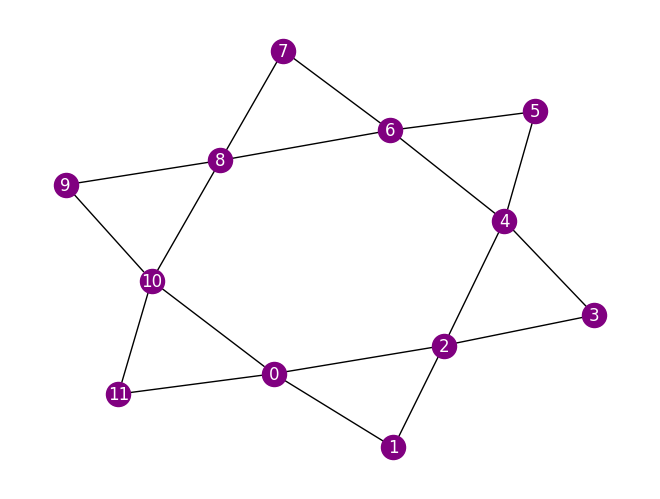

In [3]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (2, 3, t),
    (4, 5, t),
    (6, 7, t),
    (8, 9, t),
    (10, 11, t),
    (0, 2, t),
    (2, 4, t),
    (4, 6, t),
    (6, 8, t),
    (8, 10, t),
    (10, 0, t),
    (2, 1, t),
    (4, 3, t),
    (6, 5, t),
    (8, 7, t),
    (10, 9, t),
    (0, 11, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'with_labels':True,'font_color':'white','node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

Now that we have the lattice geometry, we can place each term in the Hamiltonian on its corresponding edge. This is done by using the custom `HeisenbergModel` found in the heisenberg_model.py file. This model is based on Qiskit Nature's [`IsingModel` class](https://qiskit.org/documentation/nature/stubs/qiskit_nature.problems.second_quantization.lattice.IsingModel.html) . It places $XX + YY + ZZ$ on each edge of the lattice (per the Hamiltonian's definition).

We will also need to specify how the spin-1/2 particles map to qubits. Using Qiskit nature's `LogarithmicMapper`, we can map each spin-1/2 site to a single qubit. For more information on Qiskit nature's spin mappings see [here]( https://qiskit.org/documentation/nature/stubs/qiskit_nature.mappers.second_quantization.SpinMapper.html#qiskit_nature.mappers.second_quantization.SpinMapper).

In [4]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [5]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZZIIIIIIIIII', 'IZZIIIIIIIII', 'IZIZIIIIIIII', 'IIZZIIIIIIII', 'IIIZZIIIIIII', 'IIIZIZIIIIII', 'IIIIZZIIIIII', 'IIIIIZZIIIII', 'IIIIIZIZIIII', 'IIIIIIZZIIII', 'IIIIIIIZZIII', 'IIIIIIIZIZII', 'IIIIIIIIZZII', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IZIIIIIIIIIZ', 'IIIIIIIIIZIZ', 'IIIIIIIIIIZZ', 'YYIIIIIIIIII', 'IYYIIIIIIIII', 'IYIYIIIIIIII', 'IIYYIIIIIIII', 'IIIYYIIIIIII', 'IIIYIYIIIIII', 'IIIIYYIIIIII', 'IIIIIYYIIIII', 'IIIIIYIYIIII', 'IIIIIIYYIIII', 'IIIIIIIYYIII', 'IIIIIIIYIYII', 'IIIIIIIIYYII', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IYIIIIIIIIIY', 'IIIIIIIIIYIY', 'IIIIIIIIIIYY', 'XXIIIIIIIIII', 'IXXIIIIIIIII', 'IXIXIIIIIIII', 'IIXXIIIIIIII', 'IIIXXIIIIIII', 'IIIXIXIIIIII', 'IIIIXXIIIIII', 'IIIIIXXIIIII', 'IIIIIXIXIIII', 'IIIIIIXXIIII', 'IIIIIIIXXIII', 'IIIIIIIXIXII', 'IIIIIIIIXXII', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IXIIIIIIIIIX', 'IIIIIIIIIXIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

### Compute ground state energy
With the Hamiltonian in hand, we can now calculate the expected ground state and its energy. Qiskit offers different methods to do this. The method [here](https://qiskit.org/documentation/apidoc/algorithms.html#minimum-eigensolvers) computes the ground state energy. This [method](https://qiskit.org/documentation/apidoc/algorithms.html#eigensolvers) computes the ground state ($k=0$) and potentially higher energy states if the users wishes ($k>0$).

Below is an example calculation of finding the lowest 3 energies ($k=3$) of the system using the second method. Remember that for this year's Prize, you will only need to use VQE to find the ground state energy and not any excited state energies.

In [6]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-18.         -18.         -16.96132284]


You'll note that -18 is found twice. This means there are actually two ground states for this system. The -16.96 energy is the first excited state, which is not part of this year's challenge. **For this year's Prize, we will only be judging based off the measured ground state energy. This means it does not matter which of the two ground states, or combination of them, your VQE implementation finds.**

## 2-1 VQE with local runtime primitives

To compute the ground state energy using VQE, we first pick an appropriate device. This year's Prize will use ibmq_guadalupe which has 16 qubits. This is 4 extra qubits than the Hamiltonian, so we will need to "inflate" the Hamiltonian with identity operators so we can measure 12 qubit Hamiltonian's energy expectation value on a 16 qubit device.
After inflating the Hamiltonian, the anstaz and classical optimizer components are built up. Finally, a class is defined to bring everything together for the VQE algorithm, and it's executed on a local simulator.

The code below is largely based off of this example [tutorial](https://github.com/mberna/qce22-qiskit-runtime-tutorial/blob/main/docs/tutorials/Building%20algorithms%20with%20Qiskit%20Runtime.ipynb) of using qiskit runtime primitives from IEEE week. Feel free to read through to learn more about qiskit runtime and VQE.

## 2-2 Qiskit runtime

[Qiskit runtime](https://github.com/Qiskit/qiskit-ibm-runtime) is a paradigm which brings classical and quantum computing resources closer together--speeding up quantum algorithms especially variational ones. We will be using runtime because of its [speed boost](https://research.ibm.com/blog/120x-quantum-speedup) relative to the traditional way quantum circuits are executed using qiskit. In this notebook, we'll demonstrate an example VQE executed with qiskit runtime, but we encourage you to get a deeper understanding of the tool by checking out an overview of qiskit runtime and some tutorials on the [qiskit docs section on runtime](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) as well as the IBM [research blog](https://research.ibm.com/blog/qiskit-runtime-capabilities-integration).

In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
import pandas as pd
from qiskit import IBMQ

In [8]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

# Real backend; needed for transpilation later on
guadalupe = provider.get_backend("ibmq_guadalupe")

from qiskit.providers.aer import AerSimulator

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
noisy_sim = FakeGuadalupe()

# generate a simulator that mimics the real quantum system with the latest calibration results
# Dated: 13th April 2023
noisy_sim_latest = AerSimulator.from_backend(guadalupe)

coupling_map = noisy_sim.configuration().coupling_map

/tmp/ipykernel_44295/979828823.py:3: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.load_account()
/tmp/ipykernel_44295/979828823.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


In [9]:
# Get useful information about backend (used later on)
properties = noisy_sim.properties()
config = noisy_sim.configuration()
defaults = noisy_sim.defaults()

# Get native basis gates for backend
basis_gates = config.basis_gates

# Compute average SX gate error for backend
avg_sx_err = np.mean([properties.gate_error("sx", i) for i in range(16)])
# Compute average X gate error for backend
avg_x_err = np.mean([properties.gate_error("x", i) for i in range(16)])
# Compute the average CNOT gate error for backend
avg_cx_err = np.mean(
    [properties.gate_error("cx", (cm[0], cm[1])) for cm in config.coupling_map]
)

# Display gate error averages
print(f"Average CX gate error: {avg_cx_err:.5f}")
print(f"Average single qubit SX gate error: {avg_sx_err:.5f}")
print(f"Average single qubit X gate error: {avg_x_err:.5f}")

Average CX gate error: 0.01079
Average single qubit SX gate error: 0.00040
Average single qubit X gate error: 0.00040


In [10]:
# Get useful information about backend (used later on)
properties = noisy_sim_latest.properties()
config = noisy_sim_latest.configuration()
defaults = noisy_sim_latest.defaults()

# Get native basis gates for backend
basis_gates = config.basis_gates

# Compute average SX gate error for backend
avg_sx_err = np.mean([properties.gate_error("sx", i) for i in range(16)])
# Compute average X gate error for backend
avg_x_err = np.mean([properties.gate_error("x", i) for i in range(16)])
# Compute the average CNOT gate error for backend
avg_cx_err = np.mean(
    [properties.gate_error("cx", (cm[0], cm[1])) for cm in config.coupling_map]
)

# Display gate error averages
print(f"Average CX gate error: {avg_cx_err:.5f}")
print(f"Average single qubit SX gate error: {avg_sx_err:.5f}")
print(f"Average single qubit X gate error: {avg_x_err:.5f}")

Average CX gate error: 0.01106
Average single qubit SX gate error: 0.00265
Average single qubit X gate error: 0.00265


As mentioned at the beginning of this section, the system Hamiltonian is defined over 12 qubits, but ibmq_guadalupe has 16 qubits. To execute VQE on ibmq_guadalupe, we will "inflate" the Hamilontian from 12 qubits to 16 qubits to match ibmq_guadalupe, but those extra 4 qubits will not participate in the energy expectation value. Here, we've chosen the 4 qubits that won't participate to be 0, 6, 9, 15. You may pick different qubits.

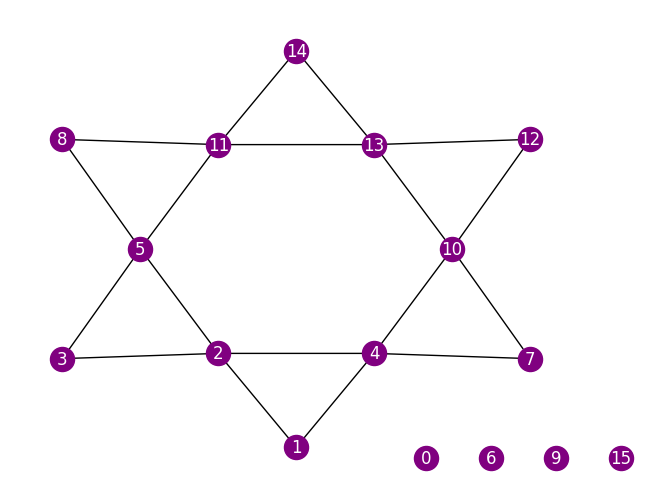

In [11]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 
                                'font_color':'white', 
                                'node_color':'purple', 
                                'pos':kagome_pos})
plt.show()

In [12]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

## 2-3 Define an ansatz

Crafting the ansatz is critical to VQE. Here we use a `Hamiltonian Variational Ansatz (HVA)` which shows promising results on ideal simulation. The main problem with HVA is that it uses at least $3|E|$ number of 2 qubit gates where $|E|$ is number of edges in the lattice. It might use more if we repeat the layers to obtain more accurate results.

Guadalupe having 16 qubits comes with a lot of noise. We tried HVA and the results are within 1% threshold on ideal simulation but the same does not hold for noisy simulations. In fact, the energy obtained using HVA close to half of the actual energy (nearly `-9 Hartree`) even after applying noise mitigation techniques.

In the HVA, the initial state |ψiniti is the ground state of a Hamiltonian $H_{init}$. The Hamiltonian $H_{init}$ is chosen in such a way that its ground state is known and easy to prepare. The ansatz state $|\theta \rangle$  is obtained by sequentially evolving along terms in $H$, according to some fixed sequence $i$,

$$
|\theta \rangle = C(\theta)|\psi_{init}\rangle,
$$

with 
$$C(\theta) = exp(−i\theta_M H_{i_M} ) \dots exp(−i\theta_2H_{i_2}) exp(−i\theta_1H_{i_1})$$.

We take $H_{init}$ to the edges with perfect matching in the lattice. Since the ground state of a single term in $H$ is the singlet state $|s\rangle = (|01\rangle -|10\rangle)/\sqrt(2)$, this means $|\psi_{init}\rangle$ is a so-called dimer covering on the relevant physical system, where every dimer is a singlet state [1]. The perfect matching is shown in the below figure

![matching](images/perfect-matching.png)

Below figure shows four coloring of the kagome lattice. This four coloring directly translates to an ansatz.

![coloring](images/colored.png)


Below figure shows the HVA, with time running from bottom to top. The initial state $|\psi_{init}\rangle$ consists of $n/2$ adjacent singlets, displayed in blue. The circuit that is applied to $|\psi_{init}\rangle$ consists of $p$ repetitions of a cycle $c$, each time with new parameters, and with one parameter per gate. The definition of HEIS gate can be found here [1]. In general, HEIS gate can be implement using $R_{xx}$, $R_{yy}$ and $R_{zz}$ upto a global phase.

<img src="images/circuit.png" width=500 height='auto'/>

\[1\] Kattemölle, J. and van Wezel, J., [Variational quantum eigensolver for the Heisenberg antiferromagnet on the kagome lattice](https://arxiv.org/pdf/2108.02175.pdf), <i>Physical Review B</i>, vol. 106, no. 21, 2022. doi:10.1103/PhysRevB.106.214429.

In [13]:
defaults = noisy_sim.defaults()
basis_gates = noisy_sim.configuration().basis_gates
basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

In [14]:
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.circuit import ParameterVector, Parameter

In [15]:
def HEIS(alpha):
    qc = QuantumCircuit(2)
    qc.rxx(alpha/4,0,1)
    qc.ryy(alpha/4,0,1)
    qc.rzz(alpha/4,0,1)
    g = qc.to_gate()
    g.name='HEIS'
    return g

def hva():
    
    qc = QuantumCircuit(12)
    
    # init layer
    init_layer = [(0,1),(2,3),(4,5),(6,7),(8,9),(10,11)]
    for edge in init_layer:
        qc.x(edge)
        qc.h(edge[0])
        qc.cnot(edge[0], edge[1])
    
    layers_input=[
        [(1,2),(3,4),(5,6),(7,8),(9,10),(11,0)],
        [(0,2),(4,6),(8,10)],
        [(2,4),(6,8),(10,0)],
    ]
    
    thetas = ParameterVector(length = 12, name = 'θ')
    
    reps = 1
    c = 0
    for r in range(reps):
        for l, layer in enumerate(layers_input):
            for e, edge in enumerate(layer):
                qc.append(HEIS(thetas[c]), edge)
                c += 1
    
    return qc, thetas

In [16]:
ansatz, thetas = hva()
ansatz.draw(fold=300)

┌───┐┌───┐                    ┌─────────────┐┌─────────────┐                ┌──────────────┐
 q_0: ┤ X ├┤ H ├──■─────────────────┤1            ├┤0            ├────────────────┤1             ├
      ├───┤└───┘┌─┴─┐┌─────────────┐│             ││             │                │              │
 q_1: ┤ X ├─────┤ X ├┤0            ├┤             ├┤  HEIS(θ[6]) ├────────────────┤              ├
      ├───┤┌───┐└───┘│  HEIS(θ[0]) ││             ││             │┌─────────────┐ │              │
 q_2: ┤ X ├┤ H ├──■──┤1            ├┤             ├┤1            ├┤0            ├─┤              ├
      ├───┤└───┘┌─┴─┐├─────────────┤│             │└─────────────┘│             │ │              │
 q_3: ┤ X ├─────┤ X ├┤0            ├┤             ├───────────────┤  HEIS(θ[9]) ├─┤              ├
      ├───┤┌───┐└───┘│  HEIS(θ[1]) ││             │┌─────────────┐│             │ │              │
 q_4: ┤ X ├┤ H ├──■──┤1            ├┤             ├┤0            ├┤1            ├─┤              ├
      ├───┤└───┘┌─┴─┐├─────────────┤│             ││             │└─────────────┘ │              │
 q_5: ┤ X ├─────┤ X ├┤0            ├┤             ├┤  HEIS(θ[7]) ├────────────────┤  HEIS(θ[11]) ├
      ├───┤┌───┐└───┘│  HEIS(θ[2]) ││  HEIS(θ[5]) ││             │┌──────────────┐│              │
 q_6: ┤ X ├┤ H ├──■──┤1            ├┤             ├┤1            ├┤0             ├┤              ├
      ├───┤└───┘┌─┴─┐├─────────────┤│             │└─────────────┘│              ││              │
 q_7: ┤ X ├─────┤ X ├┤0            ├┤             ├───────────────┤  HEIS(θ[10]) ├┤              ├
      ├───┤┌───┐└───┘│  HEIS(θ[3]) ││             │┌─────────────┐│              ││              │
 q_8: ┤ X ├┤ H ├──■──┤1            ├┤             ├┤0            ├┤1             ├┤              ├
      ├───┤└───┘┌─┴─┐├─────────────┤│             ││             │└──────────────┘│              │
 q_9: ┤ X ├─────┤ X ├┤0            ├┤             ├┤  HEIS(θ[8]) ├────────────────┤              ├
      ├───┤┌───┐└───┘│  HEIS(θ[4]) ││             ││             │                │              │
q_10: ┤ X ├┤ H ├──■──┤1            ├┤             ├┤1            ├────────────────┤0             ├
      ├───┤└───┘┌─┴─┐└─────────────┘│             │└─────────────┘                └──────────────┘
q_11: ┤ X ├─────┤ X ├───────────────┤0            ├───────────────────────────────────────────────
      └───┘     └───┘               └─────────────┘

### Match qubit layout
The ansatz is currently defined over 12 qubits, but it will be executed on guadalupe which has 16 qubits. To make the ansatz compatible with guadalupe and the inflated Hamiltonian, we can specify the qubit layout on the real device using the transpiler (shown below). We exclude the four qubits with fewest neighbors.

In [18]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]

# fake backend
ansatz_opt = transpile(ansatz, 
                       backend=noisy_sim, 
                       initial_layout=q_layout,
                       optimization_level= 3, 
                       seed_transpiler=seed)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
print('depth of the circuit:', ansatz_opt.depth())
print("total number of gates in the circuit:", sum(ansatz_opt.count_ops().values()))
ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 214), ('sx', 132), ('cx', 89), ('x', 8)])
number of parameters in the circuit: 12
depth of the circuit: 84
total number of gates in the circuit: 443


global phase: 0
                                                                                                                                                                                                                                                                                                »
 ancilla_0 -> 0 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                ┌─────────┐┌────┐        ┌────┐  ┌─────────┐                        ┌───┐┌────────────┐              ┌───┐┌────────┐  ┌────┐  ┌─────────┐           ┌───┐┌────────────┐  ┌──────────┐     ┌────┐   ┌───────────────┐      ┌────┐     ┌─────────┐            ┌───┐  ┌──────────┐ »
       q_0 -> 1 ┤ Rz(π/2) ├┤ √X ├──■─────┤ √X ├──┤ Rz(π/2) ├────────────────────────┤ X ├┤ Rz(θ[5]/4) ├──────────────┤ X ├┤ Rz(-π) ├──┤ √X ├──┤ Rz(π/2) ├───────────┤ X ├┤ Rz(θ[5]/4) ├──┤ Rz(-π/2) ├─────┤ √X ├───┤ Rz(-0.017181) ├──────┤ √X ├─────┤ Rz(π/2) ├────────────┤ X ├──┤ Rz(-π/2) ├─»
                └──┬───┬──┘└────┘┌─┴─┐┌──┴────┴─┐└──┬────┬─┘┌──────────┐            └─┬─┘└────────────┘              └─┬─┘└─┬────┬─┘  └────┘  └─────────┘           └─┬─┘└───┬────┬───┘  └──────────┘     └────┘   └───────────────┘      └────┘     └─────────┘            └─┬─┘  └──┬────┬──┘ »
       q_1 -> 2 ───┤ X ├─────────┤ X ├┤ Rz(π/2) ├───┤ √X ├──┤ Rz(-π/2) ├─────■────────┼──────────────────────■─────────┼────┤ √X ├────────────────────────────■───────┼──────┤ √X ├──────────────────────────────────────────────────────────────────────────────────■────────┼───────┤ √X ├────»
                ┌──┴───┴──┐┌────┐└───┘└──┬────┬─┘┌──┴────┴─┐└──────────┘   ┌─┴─┐      │  ┌────────────┐    ┌─┴─┐       │  ┌─┴────┴─┐  ┌────┐  ┌─────────┐   ┌─┴─┐     │  ┌───┴────┴───┐  ┌──────────┐     ┌────┐   ┌───────────────┐      ┌────┐     ┌─────────┐   ┌─┴─┐      │    ┌──┴────┴──┐ »
       q_2 -> 3 ┤ Rz(π/2) ├┤ √X ├──■─────┤ √X ├──┤ Rz(π/2) ├───────────────┤ X ├──────┼──┤ Rz(θ[0]/4) ├────┤ X ├───────┼──┤ Rz(-π) ├──┤ √X ├──┤ Rz(π/2) ├───┤ X ├─────┼──┤ Rz(θ[0]/4) ├──┤ Rz(-π/2) ├─────┤ √X ├───┤ Rz(-0.017181) ├──────┤ √X ├─────┤ Rz(π/2) ├───┤ X ├──────┼────┤ Rz(-π/2) ├─»
                └──┬───┬──┘└────┘  │     ├───┬┘  ├─────────┤   ┌────┐   ┌──┴───┴───┐  │  └────────────┘    └───┘       │  └─┬────┬─┘  └────┘  └─────────┘   └───┘     │  └───┬────┬───┘  ├─────────┬┘     └────┘   └───────────────┘      └────┘     └─────────┘   └───┘      │    └──┬────┬──┘ »
      q_11 -> 4 ───┤ X ├───────────┼─────┤ X ├───┤ Rz(π/2) ├───┤ √X ├───┤ Rz(-π/2) ├──■────────────────────────────────■────┤ √X ├────────────────────────────────────■──────┤ √X ├──────┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────■───────┤ √X ├────»
                   ├───┤         ┌─┴─┐   └─┬─┘   ├─────────┤   ├────┤   ├──────────┤                                        ├────┤                                           ├────┤      ├─────────┤                                                                                  ├────┤    »
       q_3 -> 5 ───┤ X ├─────────┤ X ├─────┼─────┤ Rz(π/2) ├───┤ √X ├───┤ Rz(-π/2) ├──■────────────────────────────────■────┤ √X ├────────────────────────────────────■──────┤ √X ├──────┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────■───────┤ √X ├────»
                   └───┘         └───┘     │     └─────────┘   └────┘   └──────────┘  │                                │    └────┘                                    │      └────┘      └─────────┘                                                                          │       └────┘    »
 ancilla_1 -> 6 ───────────────────────────┼──────────────────────────────────────────┼────────────────────────────────┼──────────────────────────────────────────────┼───────────────────────────────────────────────

## 2-4 Choose a classical optimizer
Select a [classical optimizer](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html#local-optimizers). The classical optimizer will encounter errored and stochastic results from the quantum computer due to gate errors, measurement errors, and other noise sources as well as finite sampling affects [11]. Choose a classical optimizer that pairs well with your approach to VQE. Along with choosing a classical optimizer, picking an initial set of parameters plays a significant role in VQE. 

Here we choose the L_BFGS_B optimizer which was also used by [8-9]. We take `maxiter=100` but the algorithm terminates if the energy value is stablized for some iterations. The SPSA optimizer is used for finding the initial point.

In [20]:
from qiskit.algorithms import optimizers
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.gradients import FiniteDiffEstimatorGradient

In [23]:
from qiskit.opflow import PauliExpectation

maxiter=30
stability_constant = 1
c = 0.1
alpha = 0.602
gamma = 0.101

a = 0.2

# set up the powerseries
def learning_rate():
    return powerseries(a, alpha, stability_constant)

def perturbation():
    return powerseries(c, gamma)

optimizer = optimizers.L_BFGS_B(maxiter=maxiter)

## 2-5 Initial Point Finder

Picking an initial point is plays a significant role in convergence of the VQE algorithm. For this we created a simple alogrithm to find a multiplier for the initial point. We use this for crafting the initial point for the VQE. We find a initial point multiplier in 1 dimension. We find the constant value array which gives the lowest energy. A single value is obtained which represent the constant value of the array (initial point). For example if the value returned is 2.03 then the initial point \[2.03, 2.03 ...... 2.03\].

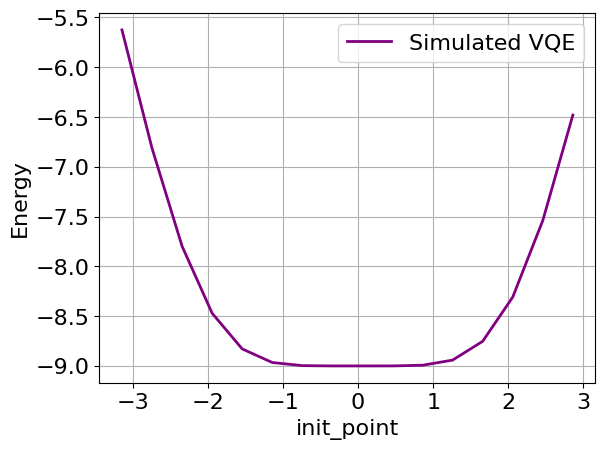

In [24]:
values = []
inits = np.arange(-np.pi, np.pi, 0.4)
for i in range(len(inits)):
    _initial_point = (inits[i]) * np.ones(shape=ansatz_opt.num_parameters)
    
    _optimizer = optimizers.SPSA(maxiter=0,
                      learning_rate=learning_rate, 
                       perturbation=perturbation)
    _estimator = Estimator()
    _gradient = FiniteDiffEstimatorGradient(_estimator, epsilon=0.001)
    _vqe = VQE(_estimator, ansatz_opt, _optimizer, gradient=_gradient, initial_point=_initial_point)
    result = _vqe.compute_minimum_eigenvalue(operator=ham_16)
    
    intermediate_info = []
    five_percent = []
    one_percent = []
    ev = result.eigenvalue
    values.append(ev)
    l = len(values)
    clear_output(wait=True)
    plt.ylabel('Energy')
    plt.xlabel('init_point')
    plt.plot(inits[:l], values, color='purple', lw=2, label='Simulated VQE')
    plt.legend()
    plt.grid()
    plt.show()

In [25]:
idx = np.where(values <= min(values))[0]
multiplier = inits[idx][0]
multiplier

0.05840734641020617

### Callback
It's important to know what's going on between the classical and quantum computer during the optimization. What parameter values is the classical optimizer picking? How does the convergence to the ground state energy behave?

Defining a callback function gives us a chance to peek in. A simple callback method is defined below. See [this tutorial](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html) for more information and be sure to read the classical [optimizers' docs](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) for what specific values can be extracted during optimization. For example [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html#qiskit.algorithms.optimizers.SPSA) returns: (nfev, parameters, value, stepsize, accepted).

In [26]:
# Define a simple callback function
intermediate_info = []
five_percent = []
one_percent = []

def callback(eval_count, parameters, value, std):
    intermediate_info.append(value)
    five_percent.append(gs_energy*(1-0.05))
    one_percent.append(gs_energy*(1-0.01))
    clear_output(wait=True)
    plt.plot(intermediate_info, color='purple', lw=2, label=f'Simulated VQE {np.round(value,2)}')
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.plot(five_percent, lw=1, label=f'5% ({np.round(gs_energy*(1-0.05),2)})')
    plt.plot(one_percent, lw=1, label=f'1% ({gs_energy*(1-0.01)})')
    plt.legend()
    plt.grid()
    plt.show()

## 2-6 Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

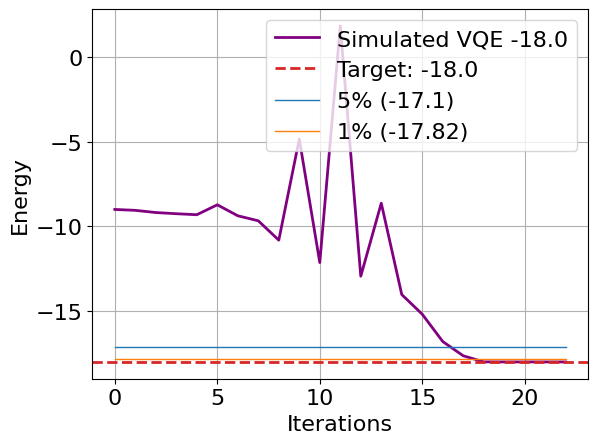

In [27]:
initial_point = multiplier * np.ones(ansatz_opt.num_parameters)

estimator = Estimator(
    options = {
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "seed": seed, 
        "seed_transpiler": seed,
    }
)

gradient = FiniteDiffEstimatorGradient(estimator, epsilon=0.001)
vqe = VQE(estimator, ansatz_opt, optimizer, callback=callback, gradient=gradient, initial_point=initial_point)
result = vqe.compute_minimum_eigenvalue(operator=ham_16)

In [28]:
print(initial_point)
print(result)

[0.05840735 0.05840735 0.05840735 0.05840735 0.05840735 0.05840735
 0.05840735 0.05840735 0.05840735 0.05840735 0.05840735 0.05840735]
{   'aux_operators_evaluated': None,
    'cost_function_evals': 23,
    'eigenvalue': -17.999999999976136,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fe6467af160>,
    'optimal_parameters': {   ParameterVectorElement(θ[11]): 4.436514763312709,
                              ParameterVectorElement(θ[8]): 1.2594714949469088e-06,
                              ParameterVectorElement(θ[2]): -5.408855935550423e-06,
                              ParameterVectorElement(θ[10]): 4.436514765193997,
                              ParameterVectorElement(θ[0]): -5.4088580913796085e-06,
                              ParameterVectorElement(θ[4]): -5.408847408012833e-06,
                              ParameterVectorElement(θ[3]): 6.283182153514871,
                              ParameterVectorElement(θ[1]): 6.283182153526618,
       

In the print out above, the ground state energy is under `eigenvalue`, and the optimal choice of parameters that goes with that energy is under `optimal_parameters`. 

## 2-7 Deparameterisation

In [29]:
def deparameterise(circuit, optimal_parameters, freeze_indices, freeze_value):
    partial_params = {}
    for (i, j) in optimal_parameters.items():
        if i.index in freeze_indices:
            partial_params[i] = freeze_value

    return circuit.assign_parameters(partial_params)

We perform deparameterisation of the ansatz. From the `result` of the VQE algorithm, we observe that all the parameters are in the vicinity of $0, \pm pi, \pm pi/2$ or their multiples. We freeze these parameters and now we are left with 3 parameter quantum circuit.

In [30]:
tqc = result.optimal_circuit
optimal_point = result.optimal_parameters

tqc = deparameterise(tqc,
                     optimal_point,
                     [0,2,4,6,7,8], 0)

tqc = deparameterise(tqc,
                     optimal_point,
                     [1,3,5], 2*np.pi)

In [31]:
tqc.num_parameters

3

We continue performing deparameterisation of the ansatz with 3 parameters.

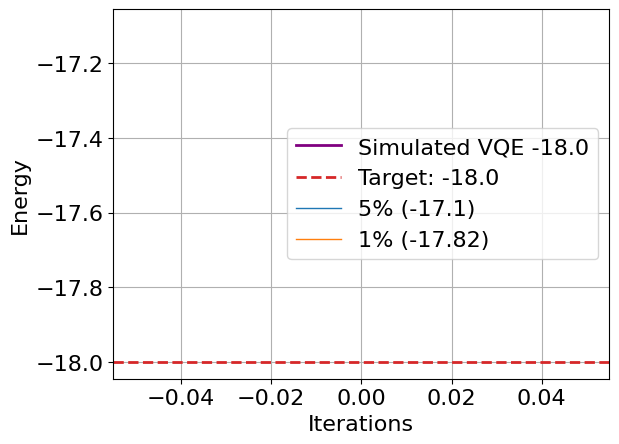

In [32]:
intermediate_info = []
five_percent = []
one_percent = []

initial_point = multiplier * np.ones(tqc.num_parameters)

gradient = FiniteDiffEstimatorGradient(estimator, epsilon=0.001)
vqe = VQE(estimator, tqc, optimizer, callback=callback, gradient=gradient, initial_point=initial_point)
result = vqe.compute_minimum_eigenvalue(operator=ham_16)

In [33]:
print(initial_point)
print(result)

[0.05840735 0.05840735 0.05840735]
{   'aux_operators_evaluated': None,
    'cost_function_evals': 1,
    'eigenvalue': -17.999999999999996,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fe664ba6910>,
    'optimal_parameters': {   ParameterVectorElement(θ[11]): 0.05840734641020617,
                              ParameterVectorElement(θ[10]): 0.05840734641020617,
                              ParameterVectorElement(θ[9]): 0.05840734641020617},
    'optimal_point': array([0.05840735, 0.05840735, 0.05840735]),
    'optimal_value': -17.999999999999996,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7fe664d05b20>,
    'optimizer_time': 1.825796127319336}


In [34]:
tqc = result.optimal_circuit
optimal_point = result.optimal_parameters

tqc = deparameterise(tqc,
                     optimal_point,
                     [9,10,11], 0)

In [35]:
job = estimator.run([tqc], [ham_16], [])
est_result = job.result()
value = est_result.values[0]
print(value)

-17.999999999999996


We froze those 3 parameters and now we are left with a fixed parameter quantum circuit which gives the groudn state energy value within 1%.

In [36]:
tqc = ansatz_opt.copy()

params = [0, 2*np.pi, 0, 2*np.pi, 0, 2*np.pi, 0, 0, 0, 0, 0, 0]
tqc = tqc.bind_parameters(params)

estimator = Estimator(
    options = {
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "seed": seed, 
        "seed_transpiler": seed,
    }
)

job = estimator.run([tqc], [ham_16], [])
est_result = job.result()
value = est_result.values[0]
print(value)

-17.999999999999996


The true ground state energy is -18.0. As a metric for how well the VQE found the ground state energy, we will compute the relative difference between -18.0 and what we just achieved with VQE. This will be the metric of performance in the judging criteria, though it's important to note that it's not the only useful metric when working with VQE. Remember that the lower the relative error the higher you will score.

In [37]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, value)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {value:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -18.0000000000
Relative error: 0.00000000


## 2-8 Noisy Simulations

We now perform noisy simulations with the ansatz fixed parameter ansatz. Specifically we simulate with `FakeGuadalupe` with its old and latest calibrated data.

Since there are only 12 qubits that we are interested in, instead of measuring all the qubits we only measure the 12 qubits and then transpile the circuit for the backend.

In [38]:
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import DynamicalDecoupling
from qiskit.circuit.library import SXGate, RZGate

In [39]:
temp_qc = transpile(ansatz.measure_all(inplace=False), 
                   backend=noisy_sim, 
                   initial_layout=q_layout,
                   optimization_level= 3, 
                   approximation_degree = 0.0,
                   seed_transpiler=seed)

temp_qc = temp_qc.bind_parameters(params)
temp_qc = RemoveBarriers()(temp_qc)

In [40]:
import mthree
from tqdm import tqdm
import seaborn as sns

### Measurement Optimization

In [41]:
import pennylane as qml

ops = []
coeffs = []

for op in ham:
    pauli_string = op.primitive.paulis[0].__str__()
    coeff = op.primitive.coeffs[0].real
    ops.append(qml.pauli.string_to_pauli_word(pauli_string))
    coeffs.append(coeff)

H = qml.Hamiltonian(coeffs, ops)
print("Number of Pauli terms in h:", len(H.ops))

groups, temp_coeffs = qml.pauli.group_observables(H.ops, H.coeffs)
print("Number of qubit-wise commuting groups:", len(groups))

wire_map = {i:i for i in range(12)}

grouped_ops = []
for group in groups:
    temp_ops = []
    for op in group:
        temp_ops.append(qml.pauli.pauli_word_to_string(op, wire_map))
    grouped_ops.append(temp_ops)

for grouped_op in grouped_ops:
    print(len(grouped_op))

Number of Pauli terms in h: 54
Number of qubit-wise commuting groups: 3
18
18
18


In [42]:
from qiskit.primitives import BackendSampler

def get_mapping(circuit):
    return mthree.utils.final_measurement_mapping(circuit)

def run_sampler(circs, sim, shots = 1024, rl = 0):
    sampler = BackendSampler(backend=sim, options={'shots':shots, 
                                                   'resilience_level':rl})

    s = time()

    job = sampler.run(circs)
    res = job.result()

    e = time()
    
    return res, e-s

def get_counts(res):
    quasi_dists = res.quasi_dists
    return [dist.binary_probabilities() for dist in quasi_dists]

def get_exp_value(counts, mapping, sim, mit=None):
    marginal_counts = []
    reduced_map = []

    for i, count in enumerate(counts):
        for grouped_op in grouped_ops[i]:  
            mc, rm = mthree.utils.marginal_distribution(count, grouped_op, mapping=mapping)
            marginal_counts.append(mc)
            reduced_map.append(rm)
            
    if mit is None:
        mit = mthree.M3Mitigation(sim)
        mit.cals_from_system(mapping)

    quasis = mit.apply_correction(marginal_counts, reduced_map)
    value = np.sum(np.array(quasis.expval())*coeffs)
    return value

### Simulation on FakeGuadalupe

We run the circuits for 100 times are report the mean and standard deviation value. Instead of running 3 circuits as mentioned before, we run a single circuit and copy its result. The results are also saved in file.

In [57]:
full_circs = [temp_qc]
mapping = get_mapping(temp_qc)

exp_vals = []
times = []

mit = mthree.M3Mitigation(noisy_sim)
mit.cals_from_system(mapping)

for _ in tqdm(range(100)):
    res, t = run_sampler(full_circs, noisy_sim, shots=1024, rl=2)
    counts = get_counts(res)
    counts = [counts[0]]*3
    exp_val = get_exp_value(counts, mapping, noisy_sim, mit)
    exp_vals.append(exp_val)
    times.append(t)
    
    with open('HVA-fake-guadalupe.npy', 'wb') as f:
        np.save(f, np.array([times]))
        np.save(f, np.array([exp_vals]))

100%|█████████████████████████████████████████| 100/100 [08:15<00:00,  4.96s/it]


In [58]:
print("Avg run time:", np.mean(times))
print("Avg exp val:", np.mean(exp_vals))
print("Std exp val:", np.std(exp_vals))

Avg run time: 4.917392761707306
Avg exp val: -5.858592073899951
Std exp val: 0.3568185353824445


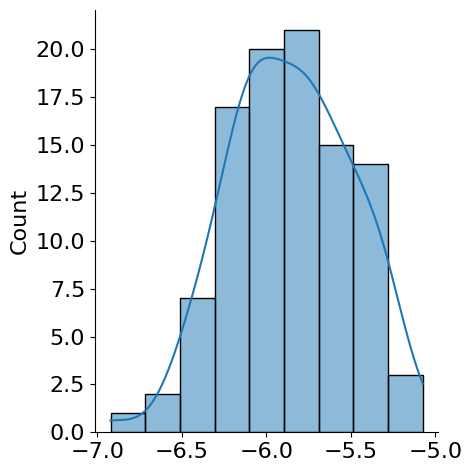

In [59]:
sns.displot(exp_vals, kde=True);

In [60]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error_max = rel_err(gs_energy, np.max(exp_vals))
rel_error_min = rel_err(gs_energy, np.min(exp_vals))
rel_error_avg = rel_err(gs_energy, np.mean(exp_vals))

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Min computed ground state energy: {np.min(exp_vals):.10f}')
print(f'Relative error: {rel_error_min:.8f}')

print(f'Max computed ground state energy: {np.max(exp_vals):.10f}')
print(f'Relative error: {rel_error_max:.8f}')

print(f'Avg computed ground state energy: {np.mean(exp_vals):.10f}')
print(f'Relative error: {rel_error_avg:.8f}')

Expected ground state energy: -18.0000000000
Min computed ground state energy: -6.9225359783
Relative error: 0.61541467
Max computed ground state energy: -5.0739202713
Relative error: 0.71811554
Avg computed ground state energy: -5.8585920739
Relative error: 0.67452266


### Results

We see that the energy value obtained are far from the actual ground state energy in a noisy simulation. This is due to the fact that the ansatz has too many 2 qubit gates (89 to be precise). Next we perform $R_{ZX}$ opitmization.

## $R_{ZX}$ Gate Optimization

In [61]:
# Transpiler passes needed to efficiently convert circuit to RZX gates
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    TemplateOptimization,
    Collect2qBlocks,
    ConsolidateBlocks,
    EchoRZXWeylDecomposition,
    Optimize1qGatesDecomposition,
    RZXCalibrationBuilderNoEcho,
)

inst_sched_map = noisy_sim.defaults().instruction_schedule_map
channel_map = noisy_sim.configuration().qubit_channel_mapping
defaults = noisy_sim.defaults()

# PassManager used on circuit with Parameterized time values
# It combines gates into blocks that act of 2 qubits then decomposes those 2-qubit blocks
# in terms of Rzx gates using the KAK decomposition
# Also optimizes single qubit gates.
pm_rzx_param = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates + ["rzx"]),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(defaults.instruction_schedule_map),
        # Scale Rzx gates to the desired angle
        RZXCalibrationBuilderNoEcho(inst_sched_map, channel_map),
        # Reduce the number of single qubit gates
        Optimize1qGatesDecomposition(basis_gates + ["rzx"]),
    ]
)

In [62]:
ansatz_opt_rzx = pm_rzx_param.run(temp_qc)

### Simulation on FakeGuadalupe

In [63]:
full_circs = [ansatz_opt_rzx]
mapping = get_mapping(ansatz_opt_rzx)

exp_vals = []
times = []

mit = mthree.M3Mitigation(noisy_sim)
mit.cals_from_system(mapping)

for _ in tqdm(range(100)):
    res, t = run_sampler(full_circs, noisy_sim, rl = 2)
    counts = get_counts(res)
    counts = [counts[0]]*3
    exp_val = get_exp_value(counts, mapping, noisy_sim, mit)
    exp_vals.append(exp_val)
    times.append(t)
    
    with open('HVA-fake-guadalupe-rzx.npy', 'wb') as f:
        np.save(f, np.array([times]))
        np.save(f, np.array([exp_vals]))

100%|█████████████████████████████████████████| 100/100 [08:52<00:00,  5.33s/it]


In [64]:
print("Avg run time:", np.mean(times))
print("Avg exp val:", np.mean(exp_vals))
print("Std exp val:", np.std(exp_vals))

Avg run time: 5.291957840919495
Avg exp val: -8.664835252460943
Std exp val: 0.32927079515996455


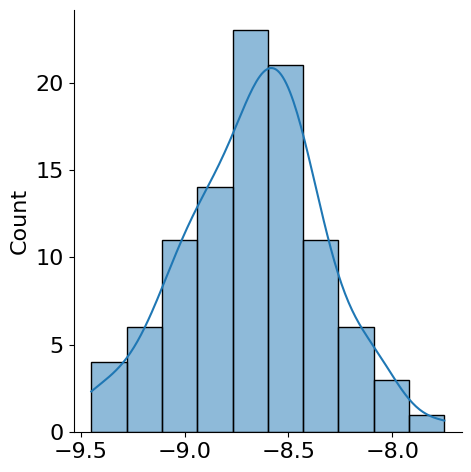

In [65]:
sns.displot(exp_vals, kde=True);

In [66]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error_max = rel_err(gs_energy, np.max(exp_vals))
rel_error_min = rel_err(gs_energy, np.min(exp_vals))
rel_error_avg = rel_err(gs_energy, np.mean(exp_vals))

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Min computed ground state energy: {np.min(exp_vals):.10f}')
print(f'Relative error: {rel_error_min:.8f}')

print(f'Max computed ground state energy: {np.max(exp_vals):.10f}')
print(f'Relative error: {rel_error_max:.8f}')

print(f'Avg computed ground state energy: {np.mean(exp_vals):.10f}')
print(f'Relative error: {rel_error_avg:.8f}')

Expected ground state energy: -18.0000000000
Min computed ground state energy: -9.4498901145
Relative error: 0.47500610
Max computed ground state energy: -7.7488805667
Relative error: 0.56950664
Avg computed ground state energy: -8.6648352525
Relative error: 0.51862026


### Results

After $R_{ZX}$ optimization, we see that results have improved but still the energy value obtained are far from the actual ground state energy. To conclude, we wanted to show that even though HVA is a powerful ansatz, we need more sophisticated noise mitigating techniques to be able to successfully execute the circuit on a real quantum computer.